In [1]:
import numpy as np 
import matplotlib.pyplot as plt

import torch
from torch import FloatTensor

import programs.boundaries as bound
import programs.NN as NN
import programs.visualize as vis

In [2]:
torch.manual_seed(1234)
np.random.seed(1234)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
net = NN.Net(device)
net = net.to(device)

In [4]:
# Ширина трещины
net.w = 1

# Вязкость проппанта
net.mu0 = 1

# Максимальная концентрация проппанта
net.cmax = 1

# Концентрация входящего проппанта
cin = 0.5

# Скорость входящего потока
v_x_inlet = 0.05

# Поток смеси
Q0 = v_x_inlet*net.w

# Веса нейронной сети
net.weights = [1,1,1]

# Протяжённость проницаемого участка
chi = 0.2

# Ширина
H = 1

# Длина
L = 1

# Число случайно сгенерированных точек для НУ и ГУ
num_points = 24000 

# Границы для t,x,y
t_min, t_max, x_min, x_max, y_min, y_max = 0, 2, 0, L, 0, H
net.boundaries = [x_min, x_max, y_min, y_max, t_min, t_max]

# Координаты для НУ и ГУ
x_range, y_range, t_range = np.random.uniform(x_min, x_max, num_points), np.random.uniform(y_min, y_max, num_points), np.random.uniform(t_min, t_max, num_points)

# Число случайно сгенерированных точек коллокации 
net.collocation = 24000 

# Функция, описывающая распределение потока/смеси вдоль интервала перфорации
psi = np.where(np.abs(y_range - np.max(y_range) / 2) < chi, 1, 0)

zeros = np.zeros(num_points)
ones = np.ones(num_points)

In [5]:
# Начальные условия

x_IC = FloatTensor(x_range.T).to(device)
y_IC = FloatTensor(y_range.T).to(device)
t_IC = FloatTensor(zeros.T).to(device)

p_initial = zeros.T
c_initial = zeros.T

pc_united = np.vstack([p_initial, c_initial]).T
f_IC = FloatTensor(pc_united).to(device)

In [6]:
# Граничные условия

mu = net.mu0 * np.power(1 - c_initial / net.cmax, -2.5)

# ГУ концентрации
c_condition = np.array([cin * psi])
cc_condition = bound.form_boundaries(x_range, y_range, t_range, c_condition, ones, zeros, left=True)
c_x, c_y, c_t, c_f = bound.form_condition_arrays(cc_condition)

# ГУ давления
cond = np.round(12 * mu * Q0 * psi / np.power(net.w, 3), 5)
p_condition = np.array([cond, cond])
p_condition = bound.form_boundaries(x_range, y_range, t_range, p_condition, ones, zeros, left=True, right=True)
p_x, p_y, p_t, p_f = bound.form_condition_arrays(p_condition)

In [7]:
print(np.max(c_condition), np.max(cond))
net.IC_x, net.IC_y, net.IC_t, net.IC_f = x_IC, y_IC, t_IC, f_IC
net.c_BC_x, net.c_BC_y, net.c_BC_t, net.c_BC_f = c_x, c_y, c_t, c_f
net.p_BC_x, net.p_BC_y, net.p_BC_t, net.p_BC_f = p_x, p_y, p_t, p_f

0.5 0.6


In [16]:
# net.full_save("opa6","data6")
# net.full_load("opa6","data6.npy")
# net.load("opa6")
# net.save("opa6")

In [17]:
net.optim = 'Adam'
net.train(max_loss=1e-5, epochs=15000)
# net.full_save("norm1","normd1")
net.optim = 'LBFGS'
net.train(max_loss=1e-5, epochs=1000)

|       Epochs        |           PDE loss            |            IC loss            |            BC loss            |         Summary loss          |
|          0          |               0               |               0               |               0               |               0               |
|          1          |    0.00044891040306538343     |     0.017984958365559578      |      0.2482300102710724       |      0.26666387915611267      |
|          2          |    0.00037390689249150455     |     0.016176952049136162      |      0.24045239388942719      |      0.2570032477378845       |
|          3          |    0.00030962927849031985     |     0.014552189037203789      |      0.23313294351100922      |      0.24799476563930511      |
|          4          |    0.00024984742049127817     |      0.01308504119515419      |      0.22627121210098267      |      0.2396060973405838       |
|          5          |     0.0001966446579899639     |     0.011784536764025688      | 

In [9]:
net.full_load("norm1.1","normd1.1.npy")

0.023560624569654465


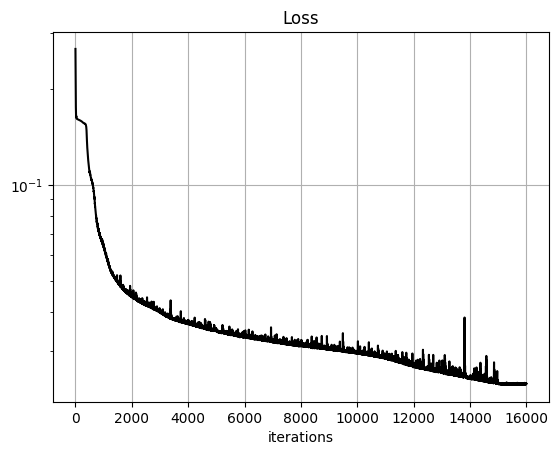

In [10]:
print (np.min(net.losses[1:]))
plt.semilogy(net.losses[1:], c='black')
plt.title('Loss')
plt.xlabel('iterations')
plt.grid()
# plt.ylim(0.01,0.02)

-0.05025674 0.12555751
-0.041631155 0.1467309


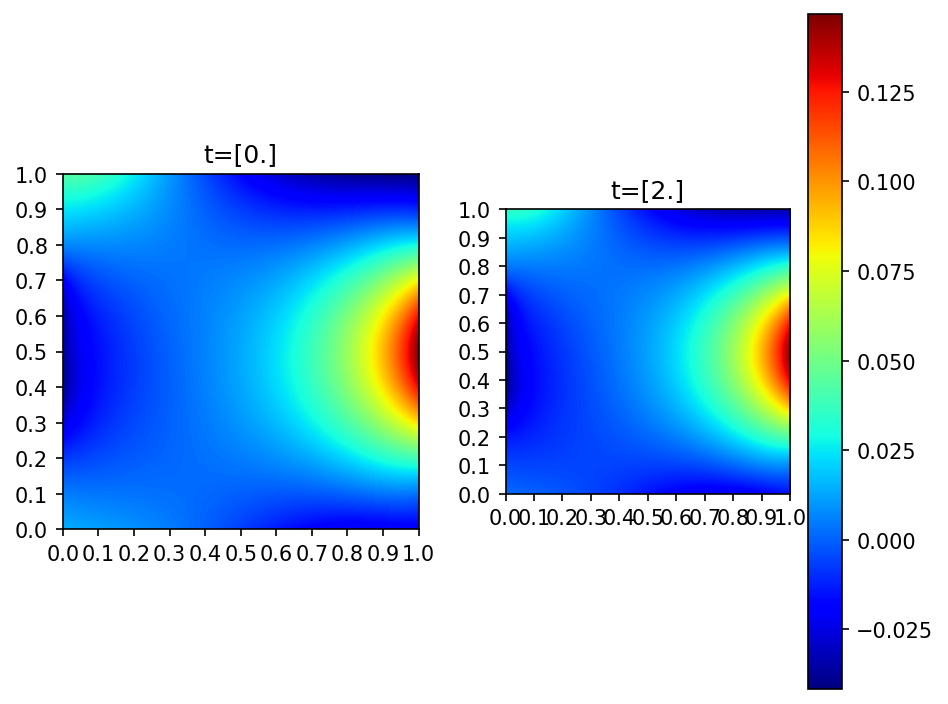

In [25]:
y = vis.plot_results(0, x_min, x_max, y_min, y_max, 2, net)

-0.05025674 0.1467309


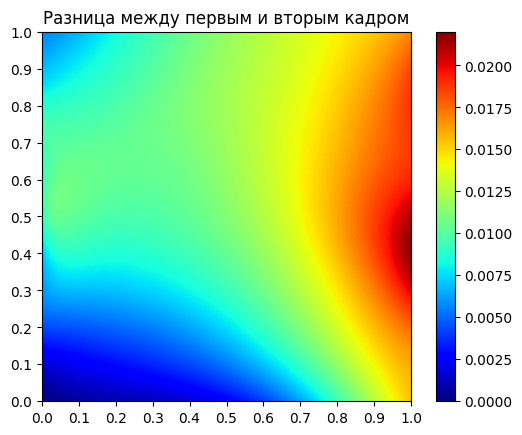

In [26]:
plt.imshow(y[1]-y[0], cmap='jet', extent=[x_min,x_max,y_min,y_max])
plt.colorbar()
plt.xlim([x_min, x_max])
plt.title('Разница между первым и вторым кадром')
plt.xticks(np.arange(x_min,x_max+0.005,0.1))
plt.yticks(np.arange(y_min,y_max+0.005,0.1))
plt.ylim([y_min, y_max])
print (np.min(y),np.max(y))